# Color GAN
*   **Goal:** Black & white to rgb images
*   **Dataset:** ImageNet/COCO-dataset

# Algorithm
*   **Cost function V(D,G):** log(D(x)) + log(1- D(G(x))), could possibly add a l1 norm accounting for the difference between groundtruth image and generated image
*   **Discrimnator (D):** maximize cost function (be able to give high probability for real x vs. generated x)
*   **Generator (G):** minimize the cost function (confuses discriminator such that discriminator gives lower probability for real x vs. generated x, e.g. 50%)
*   **Optimization:** use minibatch, ADAM optimizer (lr = 0.0001 or .00005,
momentum β1 = 0.5, β2 = 0.999.)
*   **Regularization:** try both L1 & L2 for G


In [0]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [0]:
# Import packages
import numpy as np
import math
import os
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
from torch.utils import data
from torch.nn.utils import spectral_norm
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1
from PIL import ImageFile
from matplotlib import pyplot
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
1.5.0+cu101


In [0]:
# make sure go to the project path
project_path = "/gdrive/My Drive/283 Project"
os.chdir(project_path)
!ls

 Color_GAN.ipynb   G_HD.pth.tar
 D_05-21.pth.tar  'Milestone1 (due 04 26).gdoc'
 Dataset	  'Network Parameter and Structures.gdoc'
 Dataset_small	  'papers & dataset.gdoc'
 D_HD.pth.tar	  'Progress Report due 5 17.gdoc'
 G_05-21.pth.tar   pytorch-mnist-GAN.ipynb
'GAN Tutorial'	   Trained_Models


In [0]:
# CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Load Dataset

In [0]:
#download cocodataset into google drive
# !wget http://images.cocodataset.org/zips/train2017.zip
# !unzip train2017.zip

In [0]:
# load_data
def load_data(data_folder, batch_size, train):
  '''
    PARAMETERS: 
      data_folder: path to dataset (make sure you're in project folder)
      batch_size: how many images in a batch
      train: boolean True/False

    RETURN:
      data_loader with random sample with batch_size from either "train" or "test" dataset
  '''
  transform = {
    'train': transforms.Compose(
        [transforms.Resize([64, 64]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                   std=[0.229, 0.224, 0.225])
            ]),
    'test': transforms.Compose(
        [transforms.Resize([64, 64]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                   std=[0.229, 0.224, 0.225])
            ])
  }
  data = torchvision.datasets.ImageFolder(root = data_folder, transform=transform['train' if train else 'test'])
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=4)
  return data_loader 

In [0]:
b_size = 128
# set up datafolder and read data
datafolder = "Dataset_small"
train_data = load_data(data_folder = datafolder, batch_size = b_size , train = True)  #128 training images
test_data = load_data(data_folder = datafolder, batch_size = b_size , train = True)  

# dataiter for iterating data randomly 
train_dataiter = iter(train_data)
test_dataiter = iter(test_data)

In [0]:
train_real, labels = train_dataiter.next() #get one batch of train data
print(train_real.shape) # images are in batch_size x channels(3) x width x height

torch.Size([128, 3, 64, 64])


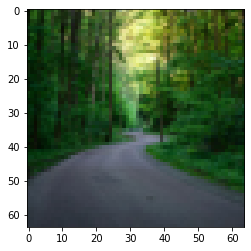

In [0]:
show_imgs(train_real[0,:,:,:])  #example of train data

## Discriminator + Generator Structure

### discriminator

In [0]:
class Discriminator_Nicole(torch.nn.Module):
    def __init__(self, inp_dim= 3*64*64, alpha=0.1, kernel_size = 3, padding = 1, stride = 2):
        super(Discriminator_Nicole, self).__init__()
        
        self.net = nn.Sequential(
            # (conv + norm + relu) * 5
            nn.Conv2d(3, 16, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(alpha),

            nn.Conv2d(16, 32, 4, stride, padding, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(alpha),

            nn.Conv2d(32, 64, 4, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(alpha),

            nn.Conv2d(64, 128, 4, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha),

            nn.Conv2d(128, 256, 4, stride, padding = 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),

            nn.Conv2d(256, 1, 1, stride=1, padding=0, bias=False)
            
        )

        self.fc1 = nn.Linear(256, 500)
        self.nonlin = nn.LeakyReLU(alpha)
        self.fc2 = nn.Linear(500, 1)
        
    def forward(self, x):
      x = self.net(x)
      # x = x.view(x.size(0), 64 * 2 * 2) #flattening x
      # x = self.nonlin(self.fc1(x))
      # x = self.fc2(x)
      x = torch.sigmoid(x.squeeze())
      return x

    def weight_initial(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

In [0]:
D = Discriminator_Nicole()
D.weight_initial()
output = D(train_real)
print(output.shape)
print(output)

###Generator (5 levels)

In [0]:
class Generator_Nicole(nn.Module):
  def __init__(self, input_size = 64*64, alpha = .2, kernel_size = 3, padding = 1, output_padding = 1, stride = 2):
    super(Generator_Nicole, self).__init__()

    # (conv + norm + relu) * 5 - > reduce size
    self.conv1 = nn.Sequential(
            nn.Conv2d(1+1, 16, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU())
            # nn.LeakyReLU(alpha, inplace=False))
    
    self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU())
            # nn.LeakyReLU(alpha, inplace=False))
    
    self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
            # nn.LeakyReLU(alpha, inplace=False))
    
    self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU())
            # nn.LeakyReLU(alpha, inplace=False))
    
    self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU())
            # nn.LeakyReLU(alpha, inplace=False))

    # (deconv + norm + relu) * 5 - > increase size
    self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU())
    
    self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128+128, 64, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
    
    self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(64+64, 32, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU())
    
    self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(32+32, 16, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU())
    
    self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(16+16, 3, kernel_size, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(3),
            nn.ReLU())


  def forward(self, x):
    x = self.conv1(x)
    p1 = x
    x = self.conv2(x)
    p2 = x
    x = self.conv3(x)
    p3 = x
    x = self.conv4(x)
    p4 = x
    x = self.conv5(x)
    
    x = self.deconv1(x)
    x = torch.cat((x, p4), 1) 
    x = self.deconv2(x)
    x = torch.cat((x, p3), 1) 
    x = self.deconv3(x)
    x = torch.cat((x, p2), 1) 
    x = self.deconv4(x)
    x = torch.cat((x, p1), 1) 
    x = self.deconv5(x)
    
    x = torch.tanh(x)
    return x

  def weight_initial(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))
      if isinstance(m, nn.ConvTranspose2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))

In [0]:
G = Generator_Nicole()
images = train_real.clone().cpu() 
images = [torchvision.transforms.ToPILImage()(x) for x in images]
images = [torchvision.transforms.Grayscale()(x) for x in images]
images = [torchvision.transforms.ToTensor()(x) for x in images]
train_real_gray = torch.stack(images)
n = (torch.randn(train_real_gray.size()) * .1)

x = torch.cat((train_real_gray, n), 1)
o = G(x)
print(o.shape)

img = o[0,:,:,:].detach().squeeze()
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

### Generator smaller

In [0]:
class Generator_Nicole(nn.Module):
  def __init__(self, input_size = 64*64, alpha = .2, kernel_size = 5, padding = 1, output_padding = 1, stride = 2):
    super(Generator_Nicole, self).__init__()

    # (conv + norm + relu) * 5 - > reduce size
    self.conv1 = nn.Sequential(
            nn.Conv2d(1+1, 64, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
            # nn.LeakyReLU(alpha, inplace=False))
    
    self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU())
            # nn.LeakyReLU(alpha, inplace=False))

    self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU())
            # nn.LeakyReLU(alpha, inplace=False))
    
    self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
    
    self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride, padding, output_padding, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU())
    
    self.deconv3 = nn.Sequential(
        nn.ConvTranspose2d(32, 3, 5, stride, padding, output_padding, bias=False),
        nn.BatchNorm2d(3),
        nn.ReLU())


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.deconv1(x)
    x = self.deconv2(x)
    x = self.deconv3(x)
    
    x = torch.tanh(x)
    return x

  def weight_initial(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))
      if isinstance(m, nn.ConvTranspose2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))

In [0]:
# G = Generator_Nicole()
# images = train_real.clone().cpu() 
# images = [torchvision.transforms.ToPILImage()(x) for x in images]
# images = [torchvision.transforms.Grayscale()(x) for x in images]
# images = [torchvision.transforms.ToTensor()(x) for x in images]
# train_real_gray = torch.stack(images)
# n = (torch.randn(train_real_gray.size()) * .1)

# x = torch.cat((train_real_gray, n), 1)
# o = G(x)
# print(o.shape)

img = o[0,:,:,:].detach().squeeze()
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

## Training

In [0]:
import torch.optim as optim
from torch.autograd import Variable

In [0]:
def train(D, G, D_opt, G_opt, criterion, L1loss, lmbda, num_e):
  '''
  PARAMTER:
    D: discriminator
    G: generator
    D_opt: discriminator Optimizer
    num_e: number of epoches
  '''
  
  LOSS = {}
  LOSS["D_loss"] = []
  LOSS["G_loss"] = []

  for e in range(num_e):
    train_dataiter = iter(train_data)
    print("epoch: %d start" % (e+1))
    D_loss = []
    D_out_real = []
    D_out_fake = []
    G_loss = []

    for train_real, _ in train_dataiter: 
      b_size = train_real.shape[0]

      ##############
      # D Training #
      ##############
      D_opt.zero_grad()
      train_real = train_real.to(device)
      # label smooth
      lab_real, lab_fake = torch.FloatTensor(b_size).uniform_(.9, 1).to(device), torch.FloatTensor(b_size).uniform_(0, .1).to(device)
      # lab_real, lab_fake = torch.ones(b_size, 1, device=device), torch.zeros(b_size, 1, device=device) #labels 
      # corresponding grayscale images
      images = train_real.clone().cpu() 
      images = [torchvision.transforms.ToPILImage()(x) for x in images]
      images = [torchvision.transforms.Grayscale()(x) for x in images]
      images = [torchvision.transforms.ToTensor()(x) for x in images]
      train_real_gray = torch.stack(images).to(device)

      # D Loss for real
      n = (torch.randn(train_real.size()) * .1) # add noise to image to make it harder for discriminator
      n = n.to(device)
      train_real = train_real + n
      D_out = D(train_real)
      lossD_real = criterion(D_out, lab_real)      

      # D Loss for fake
      n = (torch.randn(train_real_gray.size()) * .1)
      n = n.to(device)
      train_real_gray = torch.cat((train_real_gray, n), 1)
      G_fake_out = G(train_real_gray)
      D_fake_out = D(G_fake_out.detach())
      lossD_fake = criterion(D_fake_out, lab_fake)

      # D Loss total
      lossD = lossD_real + lossD_fake
      lossD.backward()
      D_opt.step()

      D_out_real.append(D_out)
      print("D_out_real: %f" % D_out.mean())
      D_out_fake.append(D_fake_out)
      print("D_out_fake: %f" % D_fake_out.mean())
      D_loss.append(lossD)
      print("D_loss: %f" % lossD)

      ##############
      # G Training #
      ##############
      G_opt.zero_grad()

      # G Loss + perceptual norm Loss between generated rgb image and groundtruth image
      D_G_out = D(G_fake_out)
      lossG = criterion(D_G_out, lab_real) #Loss for GAN LOSS
      lossG_L1 = L1loss(G_fake_out.view(G_fake_out.size(0),-1), train_real.view(train_real.size(0),-1)) #Loss for output rgb and real rgb image
      LossGAN_L1 = lossG + lmbda * lossG_L1
      LossGAN_L1.backward()
      G_opt.step()

      G_loss.append(LossGAN_L1)
      print("G_loss: %f" % LossGAN_L1)

    LOSS["D_loss"].append(torch.mean(torch.stack(D_loss)))
    LOSS["G_loss"].append(torch.mean(torch.stack(G_loss)))
    print("epoch %d finished" % (e+1))

    print("test on 16 images:")
    test_dataiter = iter(test_data)
    test_real, _ = test_dataiter.next()
    test_images = test_real.clone().cpu() 
    test_images = [torchvision.transforms.ToPILImage()(x) for x in test_images]
    test_images = [torchvision.transforms.Grayscale()(x) for x in test_images]
    test_images = [torchvision.transforms.ToTensor()(x) for x in test_images]
    test_real_gray = torch.stack(test_images).to(device)

    test_img_orig = test_real[0:16,...]
    test_img_gray = test_real_gray[0:16,...]
    n = (torch.randn(test_img_gray.size()) * .1)
    n = n.to(device)
    G_test_out = G(torch.cat((test_img_gray, n), 1))
    show_imgs(test_img_orig)
    show_imgs(test_img_gray)
    show_imgs(G_test_out)
  
  return LOSS

In [0]:
G = Generator_Nicole().to(device)
D = Discriminator_Nicole().to(device)
D.weight_initial()
G.weight_initial()
G.train()
D.train()
# for m in G.modules():
#   if isinstance(m, nn.Conv2d):
#     print(m.weight.data)

h, w = 64, 64
lr = .0001
beta1 = .5
lmbda = .0001
num_e = 100

criterion = nn.BCELoss()
L1loss = nn.L1Loss()
D_opt = optim.Adam(D.parameters(), lr=lr, betas = (beta1, .999))
G_opt = optim.Adam(G.parameters(), lr=lr, betas = (beta1, .999))

In [0]:
# train
G = G.to(device)
D = D.to(device)
G.train()
D.train()
training_loss = train(D, G, D_opt, G_opt, criterion, L1loss, lmbda, num_e)

In [0]:
def plot_history(d_hist, g_hist, e, a_hist= None):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d_hist, label='discriminator')
	pyplot.plot(g_hist, label='generator')
	pyplot.legend()
	# # plot discriminator accuracy
	# pyplot.subplot(2, 1, 2)
	# pyplot.plot(a_hist, label='acc')
	# pyplot.legend()
	# save plot to file
	pyplot.savefig('/gdrive/My Drive/Colab Notebooks/GAN/smallGAN_results_%d.png' %e)
	pyplot.close()

In [0]:
# save model
import datetime
date = datetime.datetime.now().isoformat(' ', 'seconds')[5:10]

D_path = "/gdrive/My Drive/Colab Notebooks/GAN/smallGAN_D_%d_%s.pth.tar" % (num_e,date)
G_path = "/gdrive/My Drive/Colab Notebooks/GAN/smallGAN_G_%d_%s.pth.tar" % (num_e,date)
torch.save(D.state_dict(), D_path)
torch.save(G.state_dict(), G_path)

d_hist = training_loss["D_loss"]
g_hist = training_loss["G_loss"]
plot_history(d_hist, g_hist, e = num_e)

In [0]:
# load model
D_path = "/gdrive/My Drive/Colab Notebooks/GAN/smallGAN_D_20_%s.pth.tar" % date
G_path = "/gdrive/My Drive/Colab Notebooks/GAN/smallGAN_G_20_%s.pth.tar" % date

D = Discriminator_Nicole()
D.load_state_dict(torch.load(D_path))
G = Generator_Nicole()
G.load_state_dict(torch.load(G_path))
G.eval()
D.eval()

In [0]:
# visualize result
train_real, labels = train_dataiter.next()
train_real = train_real + torch.randn(train_real.size()) * .1
# train_real.to(device)
D_out = D(train_real)
print("Discriminator output: \n")
print(D_out.mean())


images = train_real.clone().cpu() 
images = [torchvision.transforms.ToPILImage()(x) for x in images]
images = [torchvision.transforms.Grayscale()(x) for x in images]
images = [torchvision.transforms.ToTensor()(x) for x in images]
train_real_gray = torch.stack(images).cpu()

show_imgs(train_real[3,:,:,:])

gray = train_real_gray[3,:,:,:]
show_imgs(gray)

G_out = G(gray.unsqueeze(0))
show_imgs(G_out)